In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


In [68]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


# Y = b0 + b1X1 (96hr)

In [69]:
###
#cal_PMf  
###
u=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    u[i]=a.T

###
#obs_PMf
###
v=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(605, 5112)
(605, 5112)


In [70]:
XRestruct_Fun=u
YRestruct_Fun=v
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [71]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])
for i in range (0,544):
    for j in range (0,5112):
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]

In [72]:
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# GD

In [52]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [53]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + b1*x
    return y

In [54]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

# beta0 = torch.randn(6816 , requires_grad = True)
# # beta1 = torch.randn([6816 , 6816], requires_grad = True)
# beta1 = torch.randn(6816, requires_grad = True)

beta0 = torch.ones(5112, requires_grad = True)
beta1 = torch.ones(5112, requires_grad = True)

rate = 1e-2
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (30):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 7.0582, Testing loss 7.0548
Epoch 1, Training loss 7.0182, Testing loss 6.9978
Epoch 2, Training loss 6.9801, Testing loss 6.9427
Epoch 3, Training loss 6.9439, Testing loss 6.8895
Epoch 4, Training loss 6.9097, Testing loss 6.8382
Epoch 5, Training loss 6.8774, Testing loss 6.7889
Epoch 6, Training loss 6.8469, Testing loss 6.7415
Epoch 7, Training loss 6.8183, Testing loss 6.6962
Epoch 8, Training loss 6.7914, Testing loss 6.6530
Epoch 9, Training loss 6.7662, Testing loss 6.6119
Epoch 10, Training loss 6.7426, Testing loss 6.5728
Epoch 20, Training loss 6.5820, Testing loss 6.2933
Epoch 30, Training loss 6.5089, Testing loss 6.1695
Epoch 40, Training loss 6.4728, Testing loss 6.1211
Epoch 50, Training loss 6.4507, Testing loss 6.0999
Epoch 60, Training loss 6.4337, Testing loss 6.0831
Epoch 70, Training loss 6.4185, Testing loss 6.0659
Epoch 80, Training loss 6.4042, Testing loss 6.0477
Epoch 90, Training loss 6.3905, Testing loss 6.0300
Epoch 100, Training lo

Epoch 1470, Training loss 6.1035, Testing loss 5.6202
Epoch 1480, Training loss 6.1035, Testing loss 5.6202
Epoch 1490, Training loss 6.1035, Testing loss 5.6204
Epoch 1500, Training loss 6.1035, Testing loss 5.6201
Epoch 1510, Training loss 6.1035, Testing loss 5.6203
Epoch 1520, Training loss 6.1035, Testing loss 5.6203
Epoch 1530, Training loss 6.1034, Testing loss 5.6202
Epoch 1540, Training loss 6.1034, Testing loss 5.6203
Epoch 1550, Training loss 6.1034, Testing loss 5.6203
Epoch 1560, Training loss 6.1034, Testing loss 5.6204
Epoch 1570, Training loss 6.1034, Testing loss 5.6203
Epoch 1580, Training loss 6.1034, Testing loss 5.6203
Epoch 1590, Training loss 6.1034, Testing loss 5.6203
Epoch 1600, Training loss 6.1034, Testing loss 5.6204
Epoch 1610, Training loss 6.1034, Testing loss 5.6203
Epoch 1620, Training loss 6.1034, Testing loss 5.6203
Epoch 1630, Training loss 6.1034, Testing loss 5.6204
Epoch 1640, Training loss 6.1034, Testing loss 5.6203
Epoch 1650, Training loss 6.

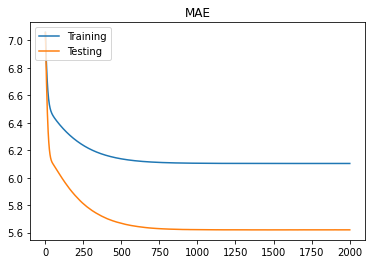

In [55]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [56]:
print(np.min(test_error))

5.619952320605696


# LBFGS

In [73]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [74]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + b1*x
    return y

In [64]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
# beta0 = torch.randn([244,6816] , requires_grad = True)
beta1 = torch.ones(5112 , requires_grad = True)

rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    # yhats_train = model(features.float() , beta0 , beta1)
    # train_loss = loss(targets.float() , yhats_train)
    # train_error[epoch] = train_loss

    # optimizer.zero_grad()
    # if epoch == 0 :
    #         train_loss.backward(retain_graph=True) 
    # else :
    #     train_loss.backward()
    # # train_loss.backward() 
    # optimizer.step()    

    def closure():
        yhats_train = model(features.float() , beta0 , beta1)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == 0 :
        #     train_loss.backward(retain_graph=True) 
        # else :
        #     train_loss.backward()
        train_loss.backward(retain_graph=True) 
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (30):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss:.4f}")
        # print('\tBeta_0 : ' , beta0.grad)
        # print('\tBeta_1 : ' , beta1.grad)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss:.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 101.4670, Testing loss 6.9203
Epoch 1, Training loss 98.0855, Testing loss 6.7712
Epoch 2, Training loss 95.7815, Testing loss 6.6602
Epoch 3, Training loss 94.1688, Testing loss 6.5749
Epoch 4, Training loss 92.9872, Testing loss 6.5067
Epoch 5, Training loss 92.0642, Testing loss 6.4486
Epoch 6, Training loss 91.3211, Testing loss 6.3988
Epoch 7, Training loss 90.6118, Testing loss 6.3500
Epoch 8, Training loss 89.7013, Testing loss 6.2907
Epoch 9, Training loss 88.2536, Testing loss 6.2088
Epoch 10, Training loss 86.3419, Testing loss 6.1253
Epoch 20, Training loss 81.4149, Testing loss 6.1263
Epoch 30, Training loss 81.2164, Testing loss 6.1363
Epoch 40, Training loss 81.2069, Testing loss 6.1354
Epoch 50, Training loss 81.2065, Testing loss 6.1355
Epoch 60, Training loss 81.2063, Testing loss 6.1356
Epoch 70, Training loss 81.2062, Testing loss 6.1357
Epoch 80, Training loss 81.2062, Testing loss 6.1357
Epoch 90, Training loss 81.2062, Testing loss 6.1357
Ep

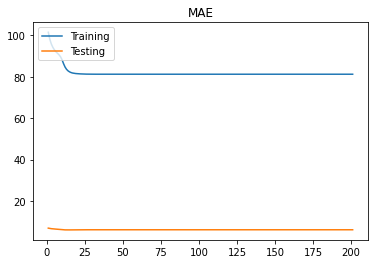

In [65]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [66]:
print(np.min(test_error))

6.061861967280766
